In [1]:
import os
import re
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')
from matplotlib.gridspec import GridSpec

import sys
# sys.path.append("../utils/")
# import simulate as mpy_simulate

sys.path.append("/gpfs/commons/home/sbanerjee/work/npd/lrma-dsc/dsc/functions")
import simulate as dsc_simulate

In [3]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/results/nnsparsh/noRx"
# h2_cut = 0.1
# pval_cut = 5e-8

zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_noRx.pkl"))
# trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_noRx.pkl"))
trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_all_with_desc.pkl"))

variant_filename = f"{data_dir}/allvar.pruned.closesttss.hugo"
variant_df = pd.read_csv(variant_filename, sep = '\t')

In [4]:
def do_standardize(Z, axis = 0, center = True, scale = True):
    '''
    Standardize (divide by standard deviation)
    and/or center (subtract mean) of a given numpy array Z

    axis: the direction along which the std / mean is aggregated.
        In other words, this axis is collapsed. For example,
        axis = 0, means the rows will aggregated (collapsed).
        In the output, the mean will be zero and std will be 1
        along the remaining axes.
        For a 2D array (matrix), use axis = 0 for column standardization
        (with mean = 0 and std = 1 along the columns, axis = 1).
        Simularly, use axis = 1 for row standardization
        (with mean = 0 and std = 1 along the rows, axis = 0).

    center: whether or not to subtract mean.

    scale: whether or not to divide by std.
    '''
    if scale:
        Znew = Z / np.std(Z, axis = axis, keepdims = True)
    else:
        Znew = Z.copy()

    if center:
        Znew = Znew - np.mean(Znew, axis = axis, keepdims = True)

    return Znew

def get_principal_components(X):
    X_cent = do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    loadings = U @ np.diag(S)
    factors  = Vt.T
    return U, S, loadings, factors

def compute_cos(xmat):
    xmat2 = xmat ** 2
    return xmat2 / np.sum(xmat2, axis = 1, keepdims = True)

def compute_contribution(xmat):
    xmat2 = xmat ** 2
    return xmat2 / np.sum(xmat2, axis = 0, keepdims = True)

In [5]:
res_filename = os.path.join(result_dir, "nnm_model_r65536_iter1000.pkl")
with (open(res_filename, "rb")) as fh:
    nnm_model = pickle.load(fh)
    
res_filename = os.path.join(result_dir, "nnm_sparse_model_r65536_iter1000.pkl")
with (open(res_filename, "rb")) as fh:
    nnm_sparse_model = pickle.load(fh)

res_filename = os.path.join(result_dir, "rpca_model.pkl")
with (open(res_filename, "rb")) as fh:
    rpca_model = pickle.load(fh)

In [6]:
nnm_lowX = nnm_model['X_']
nnm_sparse_lowX = nnm_sparse_model['X_']
rpca_lowX = rpca_model['L_']
X = np.array(zscore_df.values.T)
X_cent = X - np.mean(X, axis = 0, keepdims = True)

In [7]:
nnm_lowX.shape

(2110, 51368)

In [8]:
from scipy.stats import pearsonr
def get_pearsonr(X, Y):
    res = [pearsonr(X[:, i], Y[:, i]).statistic for i in range(X.shape[1])]
    return np.array(res)

itop = 10000
nnm_lowX_corr = get_pearsonr(nnm_lowX[:, :itop], X_cent[:, :itop])
nnm_sparse_lowX_corr = get_pearsonr(nnm_sparse_lowX[:, :itop], X_cent[:, :itop])
rpca_lowX_corr = get_pearsonr(rpca_lowX[:, :itop], X_cent[:, :itop])

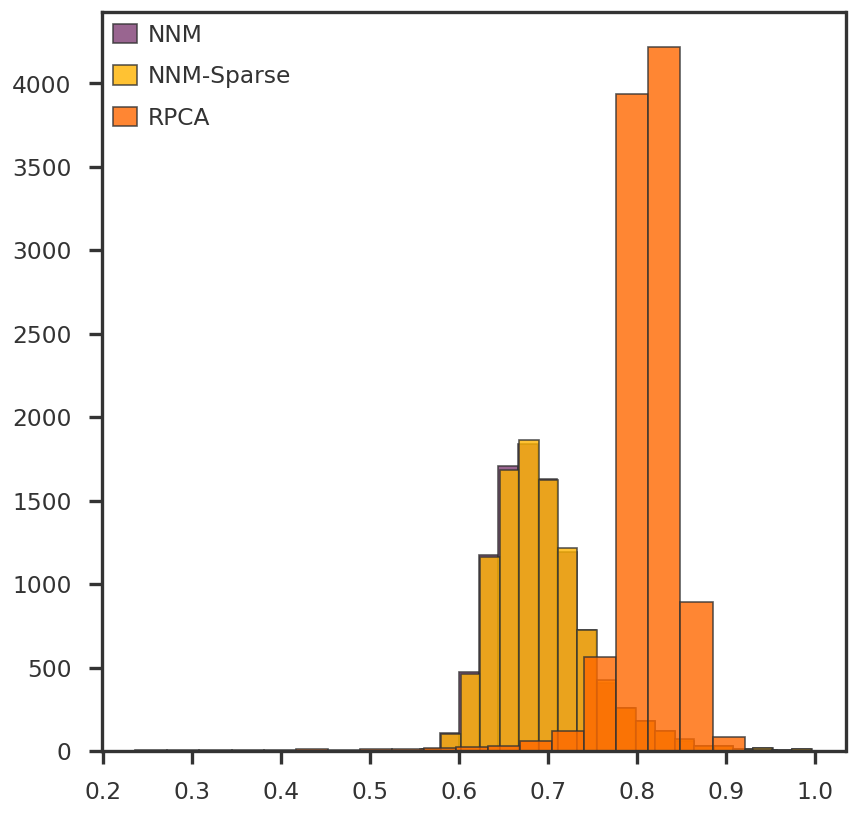

In [9]:
from matplotlib import colormaps as mpl_cmaps
import matplotlib.colors as mpl_colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_heatmap(ax, X, vmax = 1.0):
    '''
    Helps to plot a heatmap
    '''
    cmap1 = mpl_cmaps.get_cmap("YlOrRd").copy()
    cmap1.set_bad("w")
    norm1 = mpl_colors.TwoSlopeNorm(vmin = 0., vcenter = vmax / 2., vmax = vmax)
    im1 = ax.imshow(X.T, cmap = cmap1, norm = norm1, interpolation='nearest', origin = 'upper')

    ax.tick_params(bottom = False, top = True, left = True, right = False,
                    labelbottom = False, labeltop = True, labelleft = True, labelright = False)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(im1, cax=cax, fraction = 0.1)
    return

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)
ax1.hist(nnm_lowX_corr, alpha = 0.8, label = "NNM")
ax1.hist(nnm_sparse_lowX_corr, alpha = 0.8, label = "NNM-Sparse")
ax1.hist(rpca_lowX_corr, alpha = 0.8, label = "RPCA")

ax1.legend()
plt.show()

In [10]:
U_nnm, S_nnm, loadings_nnm, factors_nnm = get_principal_components(nnm_lowX)
U_nnm_sparse, S_nnm_sparse, loadings_nnm_sparse, factors_nnm_sparse = get_principal_components(nnm_sparse_lowX)
U_rpca, S_rpca, loadings_rpca, factors_rpca = get_principal_components(rpca_lowX)

cos2_pheno_nnm   = compute_cos(loadings_nnm)
cos2_variant_nnm = compute_cos(factors_nnm)
contribution_pheno_nnm   = compute_contribution(loadings_nnm)
contribution_variant_nnm = compute_contribution(factors_nnm)

cos2_pheno_nnm_sparse   = compute_cos(loadings_nnm_sparse)
cos2_variant_nnm_sparse = compute_cos(factors_nnm_sparse)
contribution_pheno_nnm_sparse   = compute_contribution(loadings_nnm_sparse)
contribution_variant_nnm_sparse = compute_contribution(factors_nnm_sparse)

cos2_pheno_rpca   = compute_cos(loadings_rpca)
cos2_variant_rpca = compute_cos(factors_rpca)
contribution_pheno_rpca   = compute_contribution(loadings_rpca)
contribution_variant_rpca = compute_contribution(factors_rpca)

In [11]:
pheno_zindex = [int(x[1:]) for x in zscore_df.columns]
trait_df_noRx = trait_df.loc[trait_df['zindex'].isin(pheno_zindex)]
trait_df_noRx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2110 entries, 0 to 2482
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zindex                       2110 non-null   int64  
 1   trait_type                   2110 non-null   object 
 2   phenocode                    2110 non-null   object 
 3   pheno_sex                    2110 non-null   object 
 4   coding                       267 non-null    object 
 5   modifier                     394 non-null    object 
 6   description                  2110 non-null   object 
 7   description_more             1408 non-null   object 
 8   coding_description           261 non-null    object 
 9   category                     2072 non-null   object 
 10  BIN_QT                       2110 non-null   object 
 11  n_cases_EUR                  2110 non-null   int64  
 12  n_controls_EUR               1304 non-null   float64
 13  N                      

In [12]:
trait_df_noRx.query("description == 'Triglycerides'")

,zindex,trait_type,phenocode,pheno_sex,coding,modifier,description,description_more,coding_description,category,BIN_QT,n_cases_EUR,n_controls_EUR,N,Neff,filename,aws_link,estimates.final.h2_observed,long_description,short_description
1704,1705,biomarkers,30870,both_sexes,NaN,irnt,Triglycerides,NaN,NaN,Biological samples > Assay results > Blood ass...,QT,400639,NaN,400639,400639.0,biomarkers-30870-both_sexes-irnt.tsv.bgz,https://pan-ukb-us-east-1.s3.amazonaws.com/sum...,0.177,Triglycerides,Triglycerides


In [13]:
zindex = 1705

trait_indices = np.array(trait_df_noRx.index)
tidx = np.searchsorted(trait_indices, zindex - 1)
top_factor = np.argsort(cos2_pheno_nnm[tidx,:])[::-1][0]

In [14]:
top_variant_idx = np.argsort(contribution_variant_nnm[:, top_factor])[::-1][:20]
top_variant_idx

array([47528, 20099, 19962, 20101, 47519, 20103, 47533, 20096, 25698,
        9008,  9026, 50836, 47482, 13371,  8988, 47555, 47488, 47477,
       47532, 47503])

In [15]:
from sklearn.linear_model import LinearRegression
linreg_model = LinearRegression()
linreg_model.fit(X_cent, loadings_nnm[:, top_factor])

LinearRegression()

In [27]:
np.linalg.norm(nnm_lowX, ord='nuc')

58373.92678049684

In [28]:
np.linalg.norm(nnm_sparse_lowX, ord = 'nuc')

58539.926897612706

In [33]:
np.linalg.norm(nnm_sparse_model['M_'], ord = 1)

249.284628172505

In [34]:
np.linalg.norm(X_cent, ord = 1)

4012.358899333438

In [36]:
np.linalg.matrix_rank(nnm_sparse_lowX)

629

In [17]:
from sklearn.linear_model import LinearRegression

nfactor = factors_nnm.shape[1]
select_factors = np.linspace(5, nfactor - 5, num = 4, dtype = int)

linreg_models = dict()
for ifact in select_factors:
    linreg_models[ifact] = LinearRegression()
    linreg_models[ifact].fit(X_cent, loadings_nnm[:, ifact])

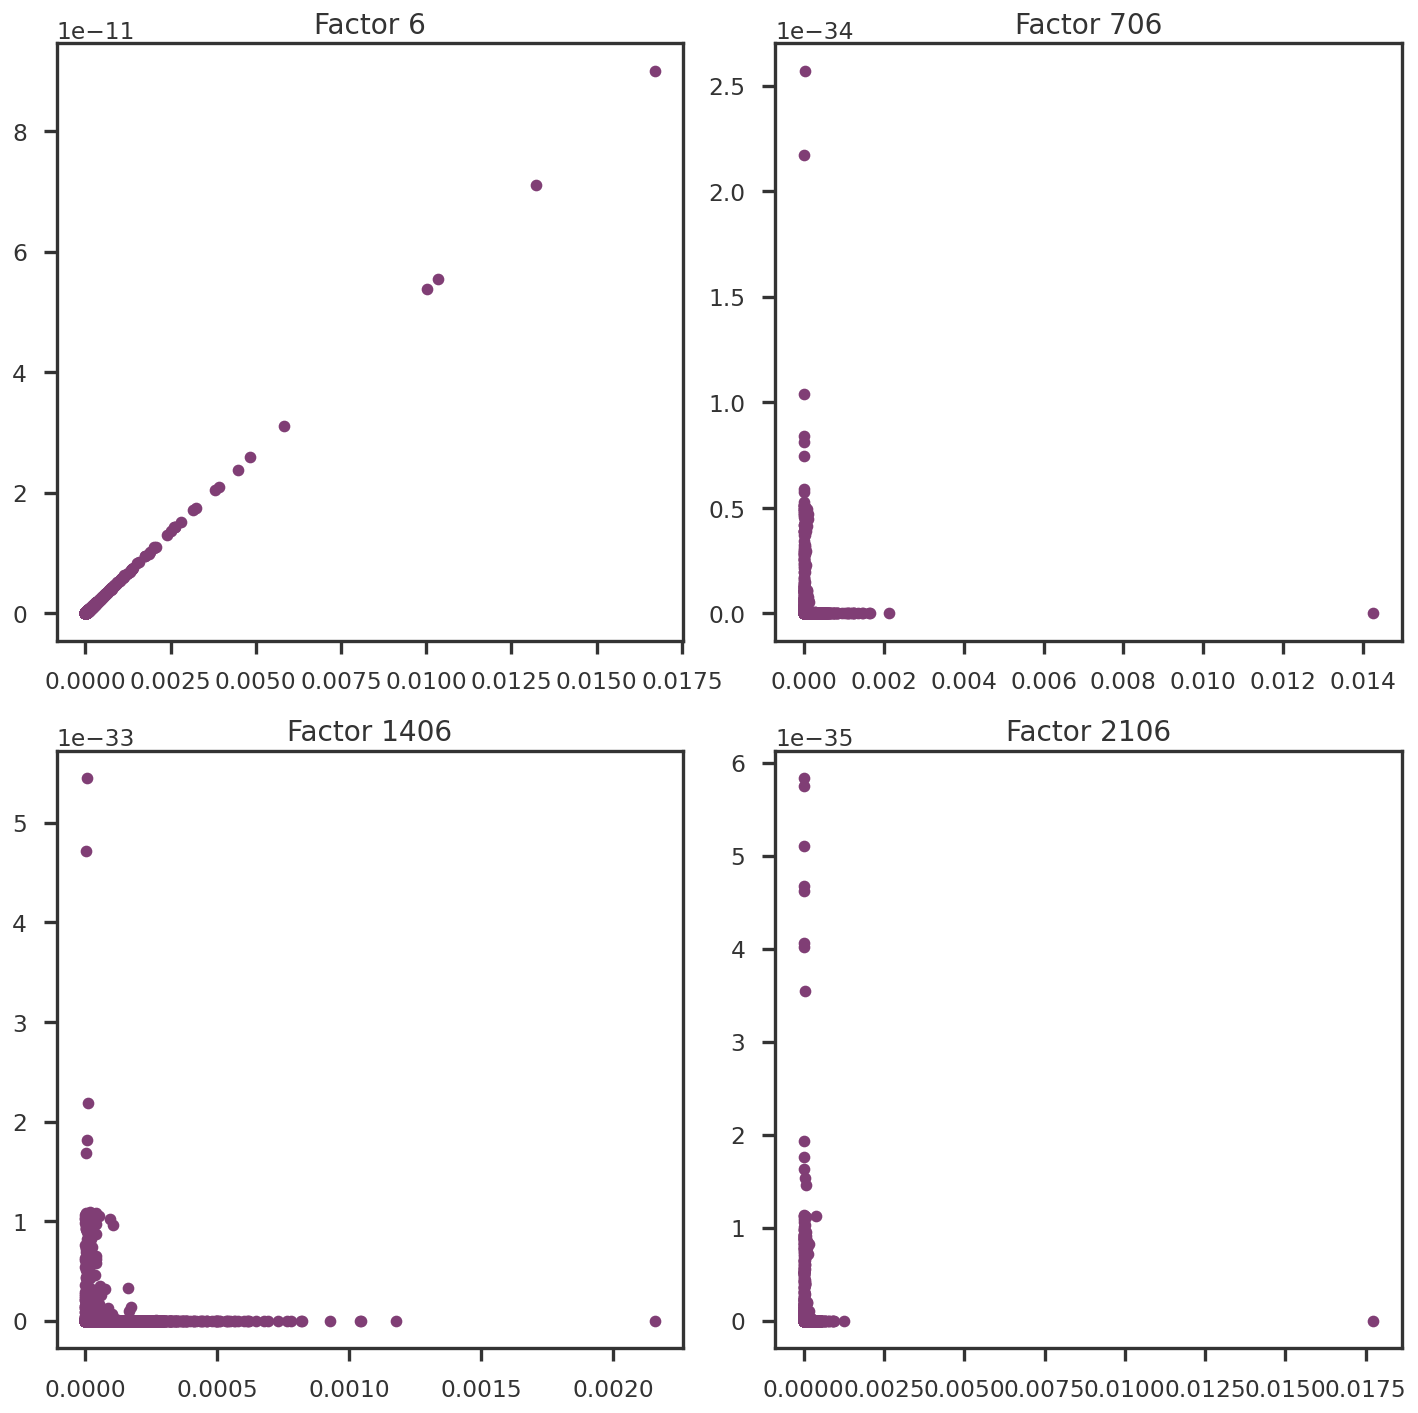

In [18]:
fig = plt.figure(figsize = (12, 12))
axs = [None for i in range(4)]
for i in range(4):
    axs[i] = fig.add_subplot(2, 2,i+1)
    ifact = select_factors[i]
    axs[i].scatter(contribution_variant_nnm[:, ifact], np.square(linreg_models[ifact].coef_))
    axs[i].set_title(f"Factor {ifact + 1}")

plt.tight_layout()
plt.show()

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, r_regression

select_factors = np.linspace(5, 200, num = 8, dtype = int)

kbest_models_r2 = dict()
for ifact in select_factors:
    kbest_models_r2[ifact] = SelectKBest(r_regression, k = 100)
    kbest_models_r2[ifact].fit(X_cent, loadings_nnm[:, ifact])

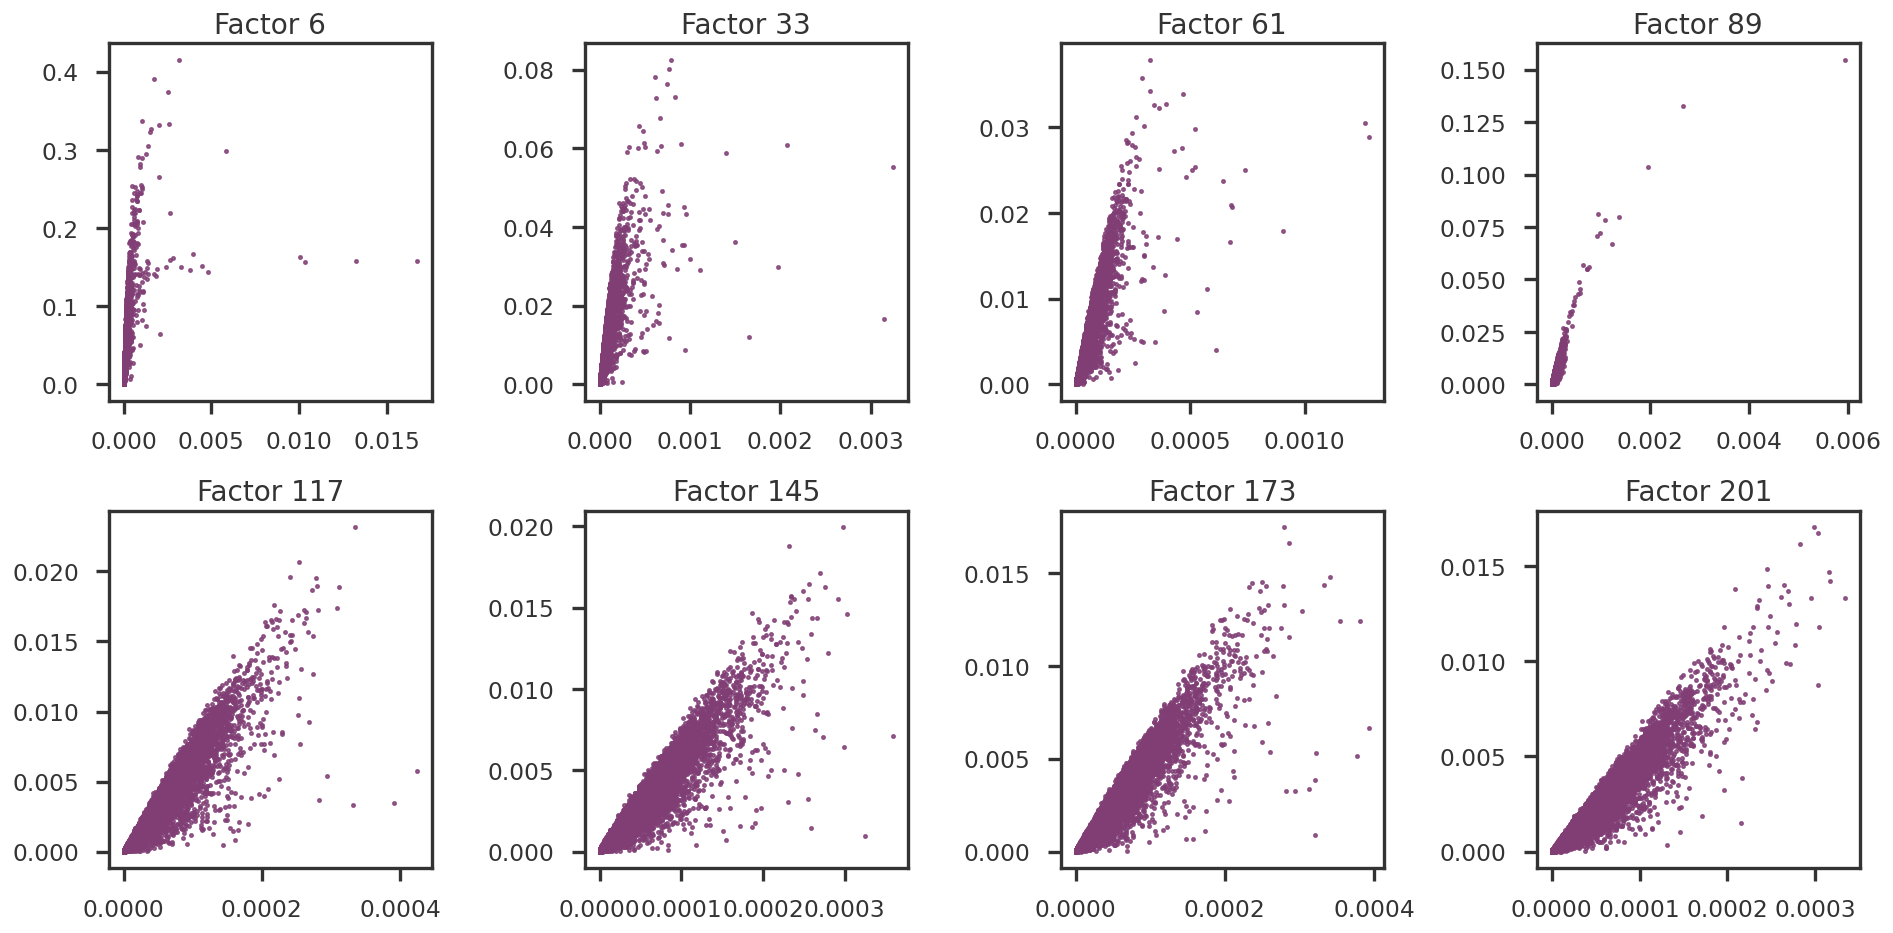

In [20]:
fig = plt.figure(figsize = (16, 8))
axs = [None for i in range(8)]

for i in range(8):
    axs[i] = fig.add_subplot(2, 4, i+1)
    ifact = select_factors[i]
    axs[i].scatter(contribution_variant_nnm[:, ifact], 
                   np.square(kbest_models_r2[ifact].scores_),
                   s = 4, alpha = 0.8)
    axs[i].set_title(f"Factor {ifact + 1}")

plt.tight_layout()
plt.show()

In [21]:
kbest_models_fs = dict()
for ifact in select_factors:
    kbest_models_fs[ifact] = SelectKBest(f_regression, k = 100)
    kbest_models_fs[ifact].fit(X_cent, loadings_nnm[:, ifact])

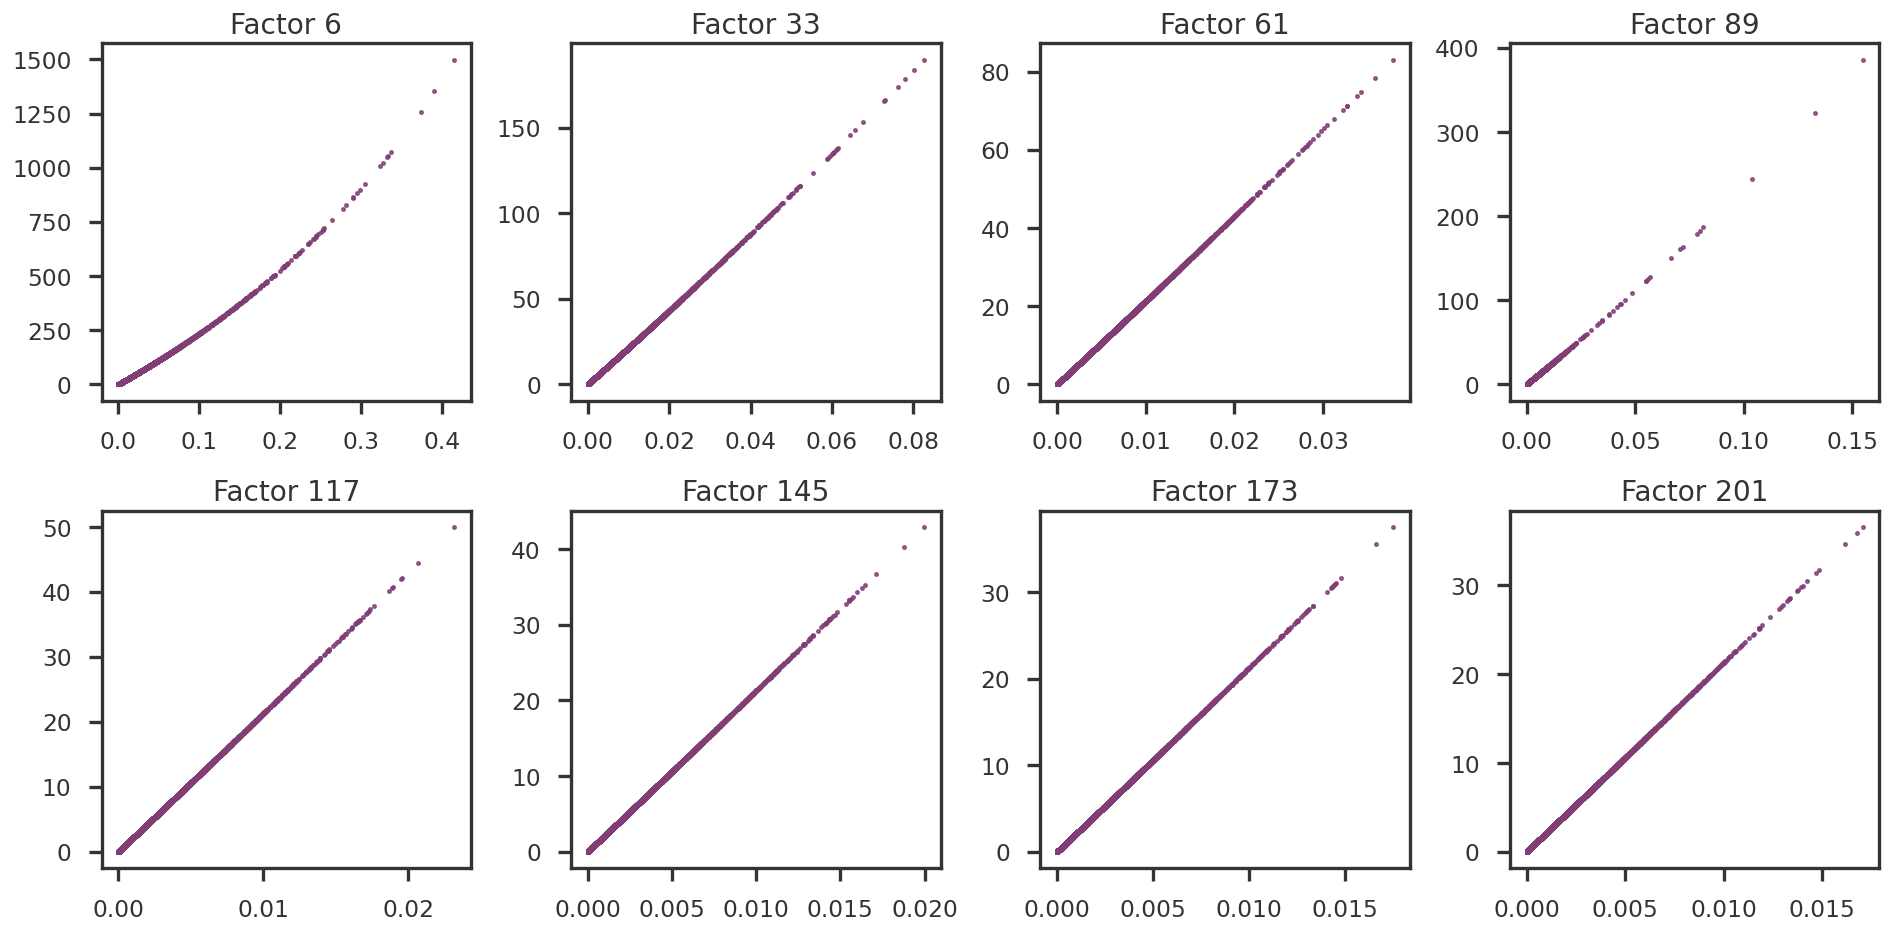

In [22]:
fig = plt.figure(figsize = (16, 8))
axs = [None for i in range(8)]

for i in range(8):
    axs[i] = fig.add_subplot(2, 4, i+1)
    ifact = select_factors[i]
    axs[i].scatter(np.square(kbest_models_r2[ifact].scores_), 
                   np.abs(kbest_models_fs[ifact].scores_),
                   s = 4, alpha = 0.8)
    axs[i].set_title(f"Factor {ifact + 1}")

plt.tight_layout()
plt.show()

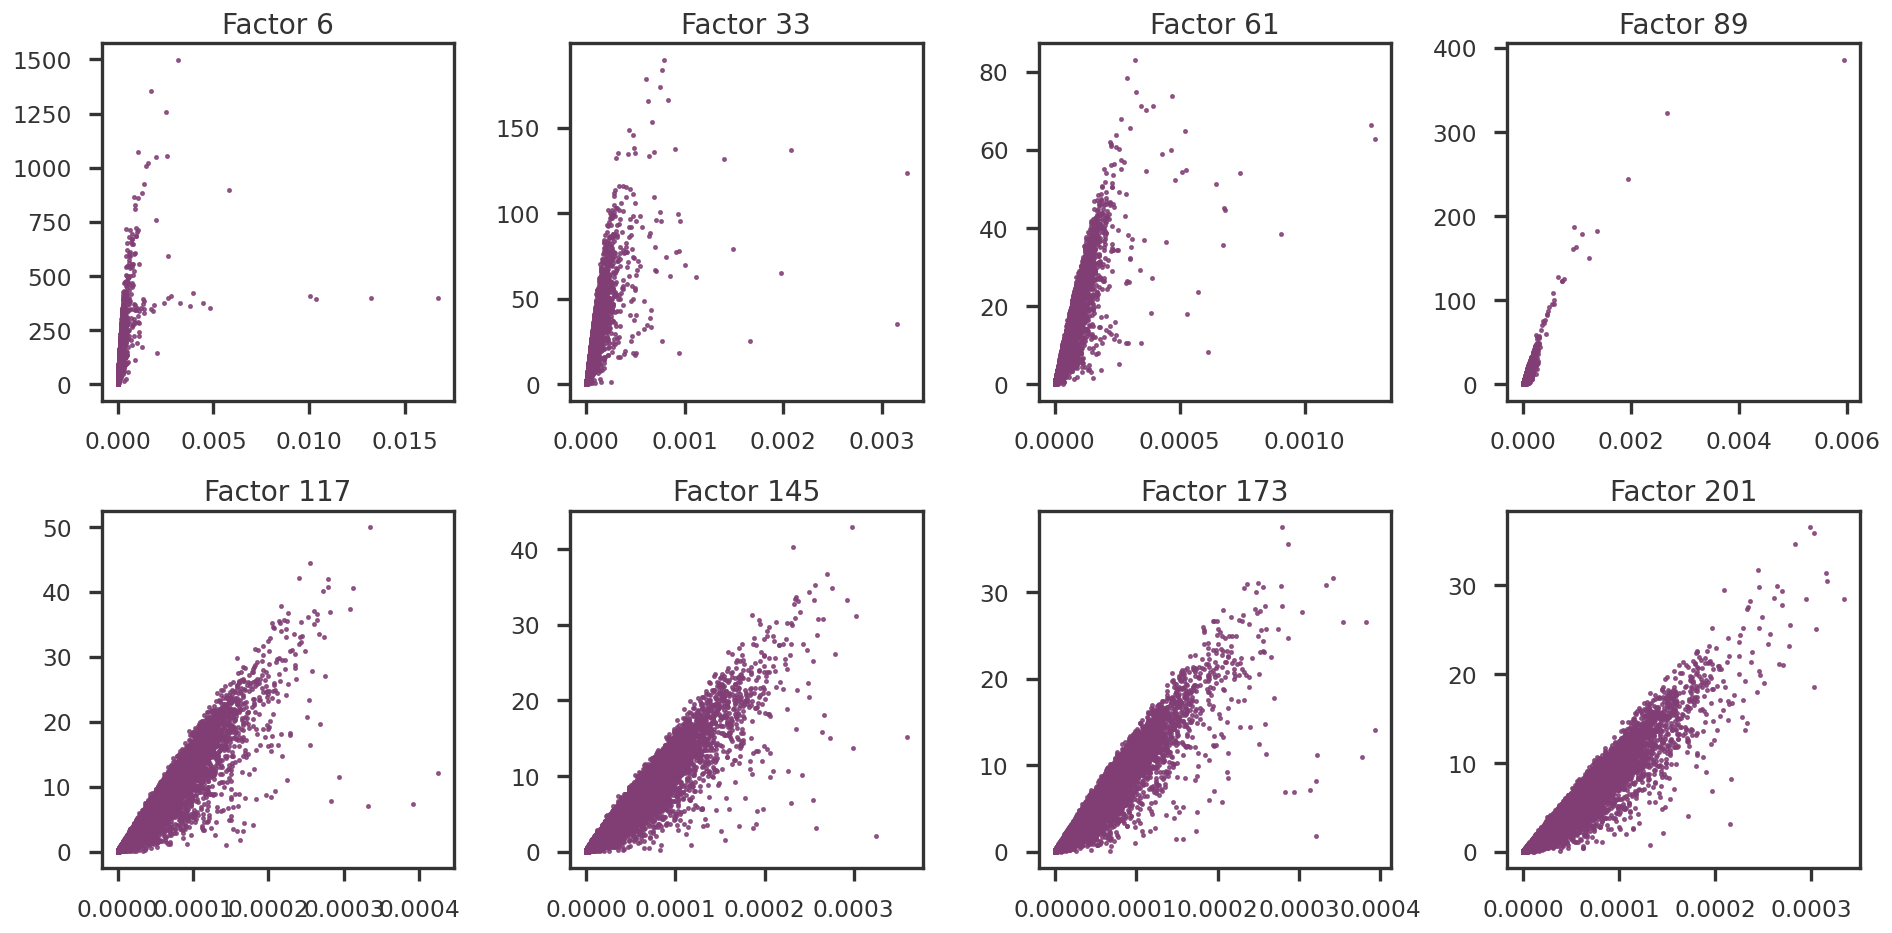

In [24]:
fig = plt.figure(figsize = (16, 8))
axs = [None for i in range(8)]

for i in range(8):
    axs[i] = fig.add_subplot(2, 4, i+1)
    ifact = select_factors[i]
    axs[i].scatter(contribution_variant_nnm[:, ifact], 
                   np.abs(kbest_models_fs[ifact].scores_),
                   s = 4, alpha = 0.8)
    axs[i].set_title(f"Factor {ifact + 1}")

plt.tight_layout()
plt.show()

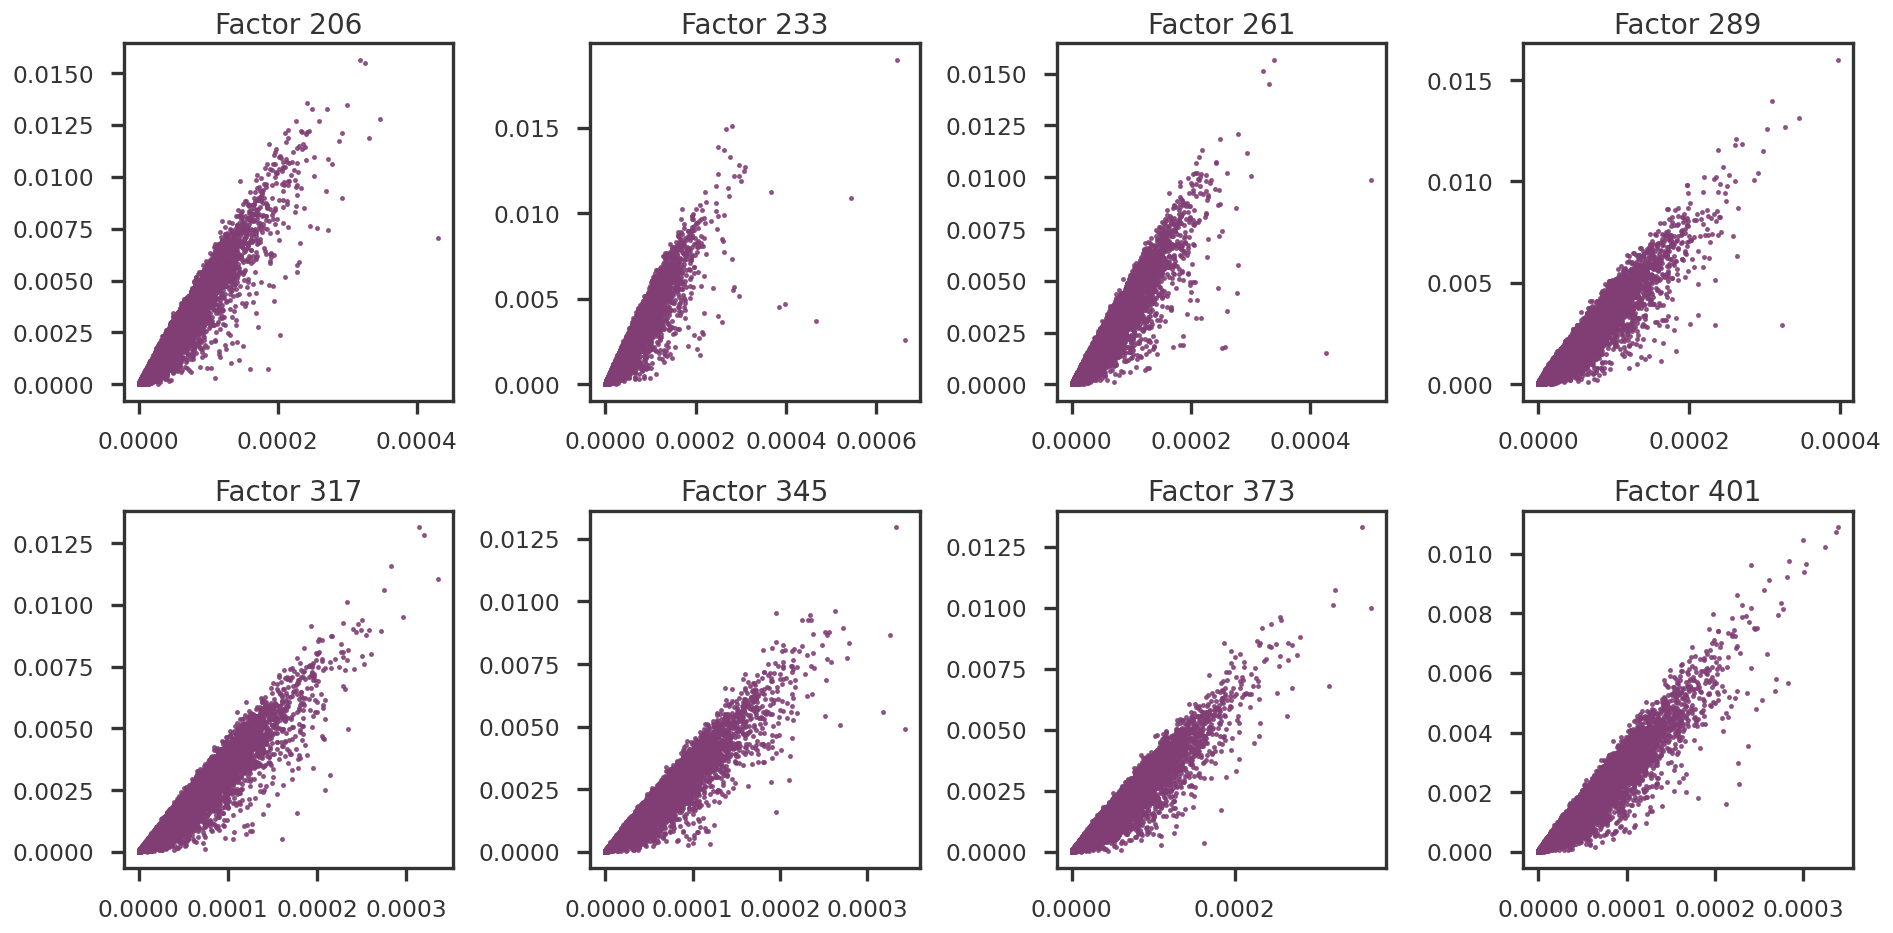

In [25]:
select_factors = np.linspace(205, 400, num = 8, dtype = int)

kbest_models_r2_205 = dict()
for ifact in select_factors:
    kbest_models_r2_205[ifact] = SelectKBest(r_regression, k = 100)
    kbest_models_r2_205[ifact].fit(X_cent, loadings_nnm[:, ifact])
    
fig = plt.figure(figsize = (16, 8))
axs = [None for i in range(8)]

for i in range(8):
    axs[i] = fig.add_subplot(2, 4, i+1)
    ifact = select_factors[i]
    axs[i].scatter(contribution_variant_nnm[:, ifact], 
                   np.square(kbest_models_r2_205[ifact].scores_),
                   s = 4, alpha = 0.8)
    axs[i].set_title(f"Factor {ifact + 1}")

plt.tight_layout()
plt.show()

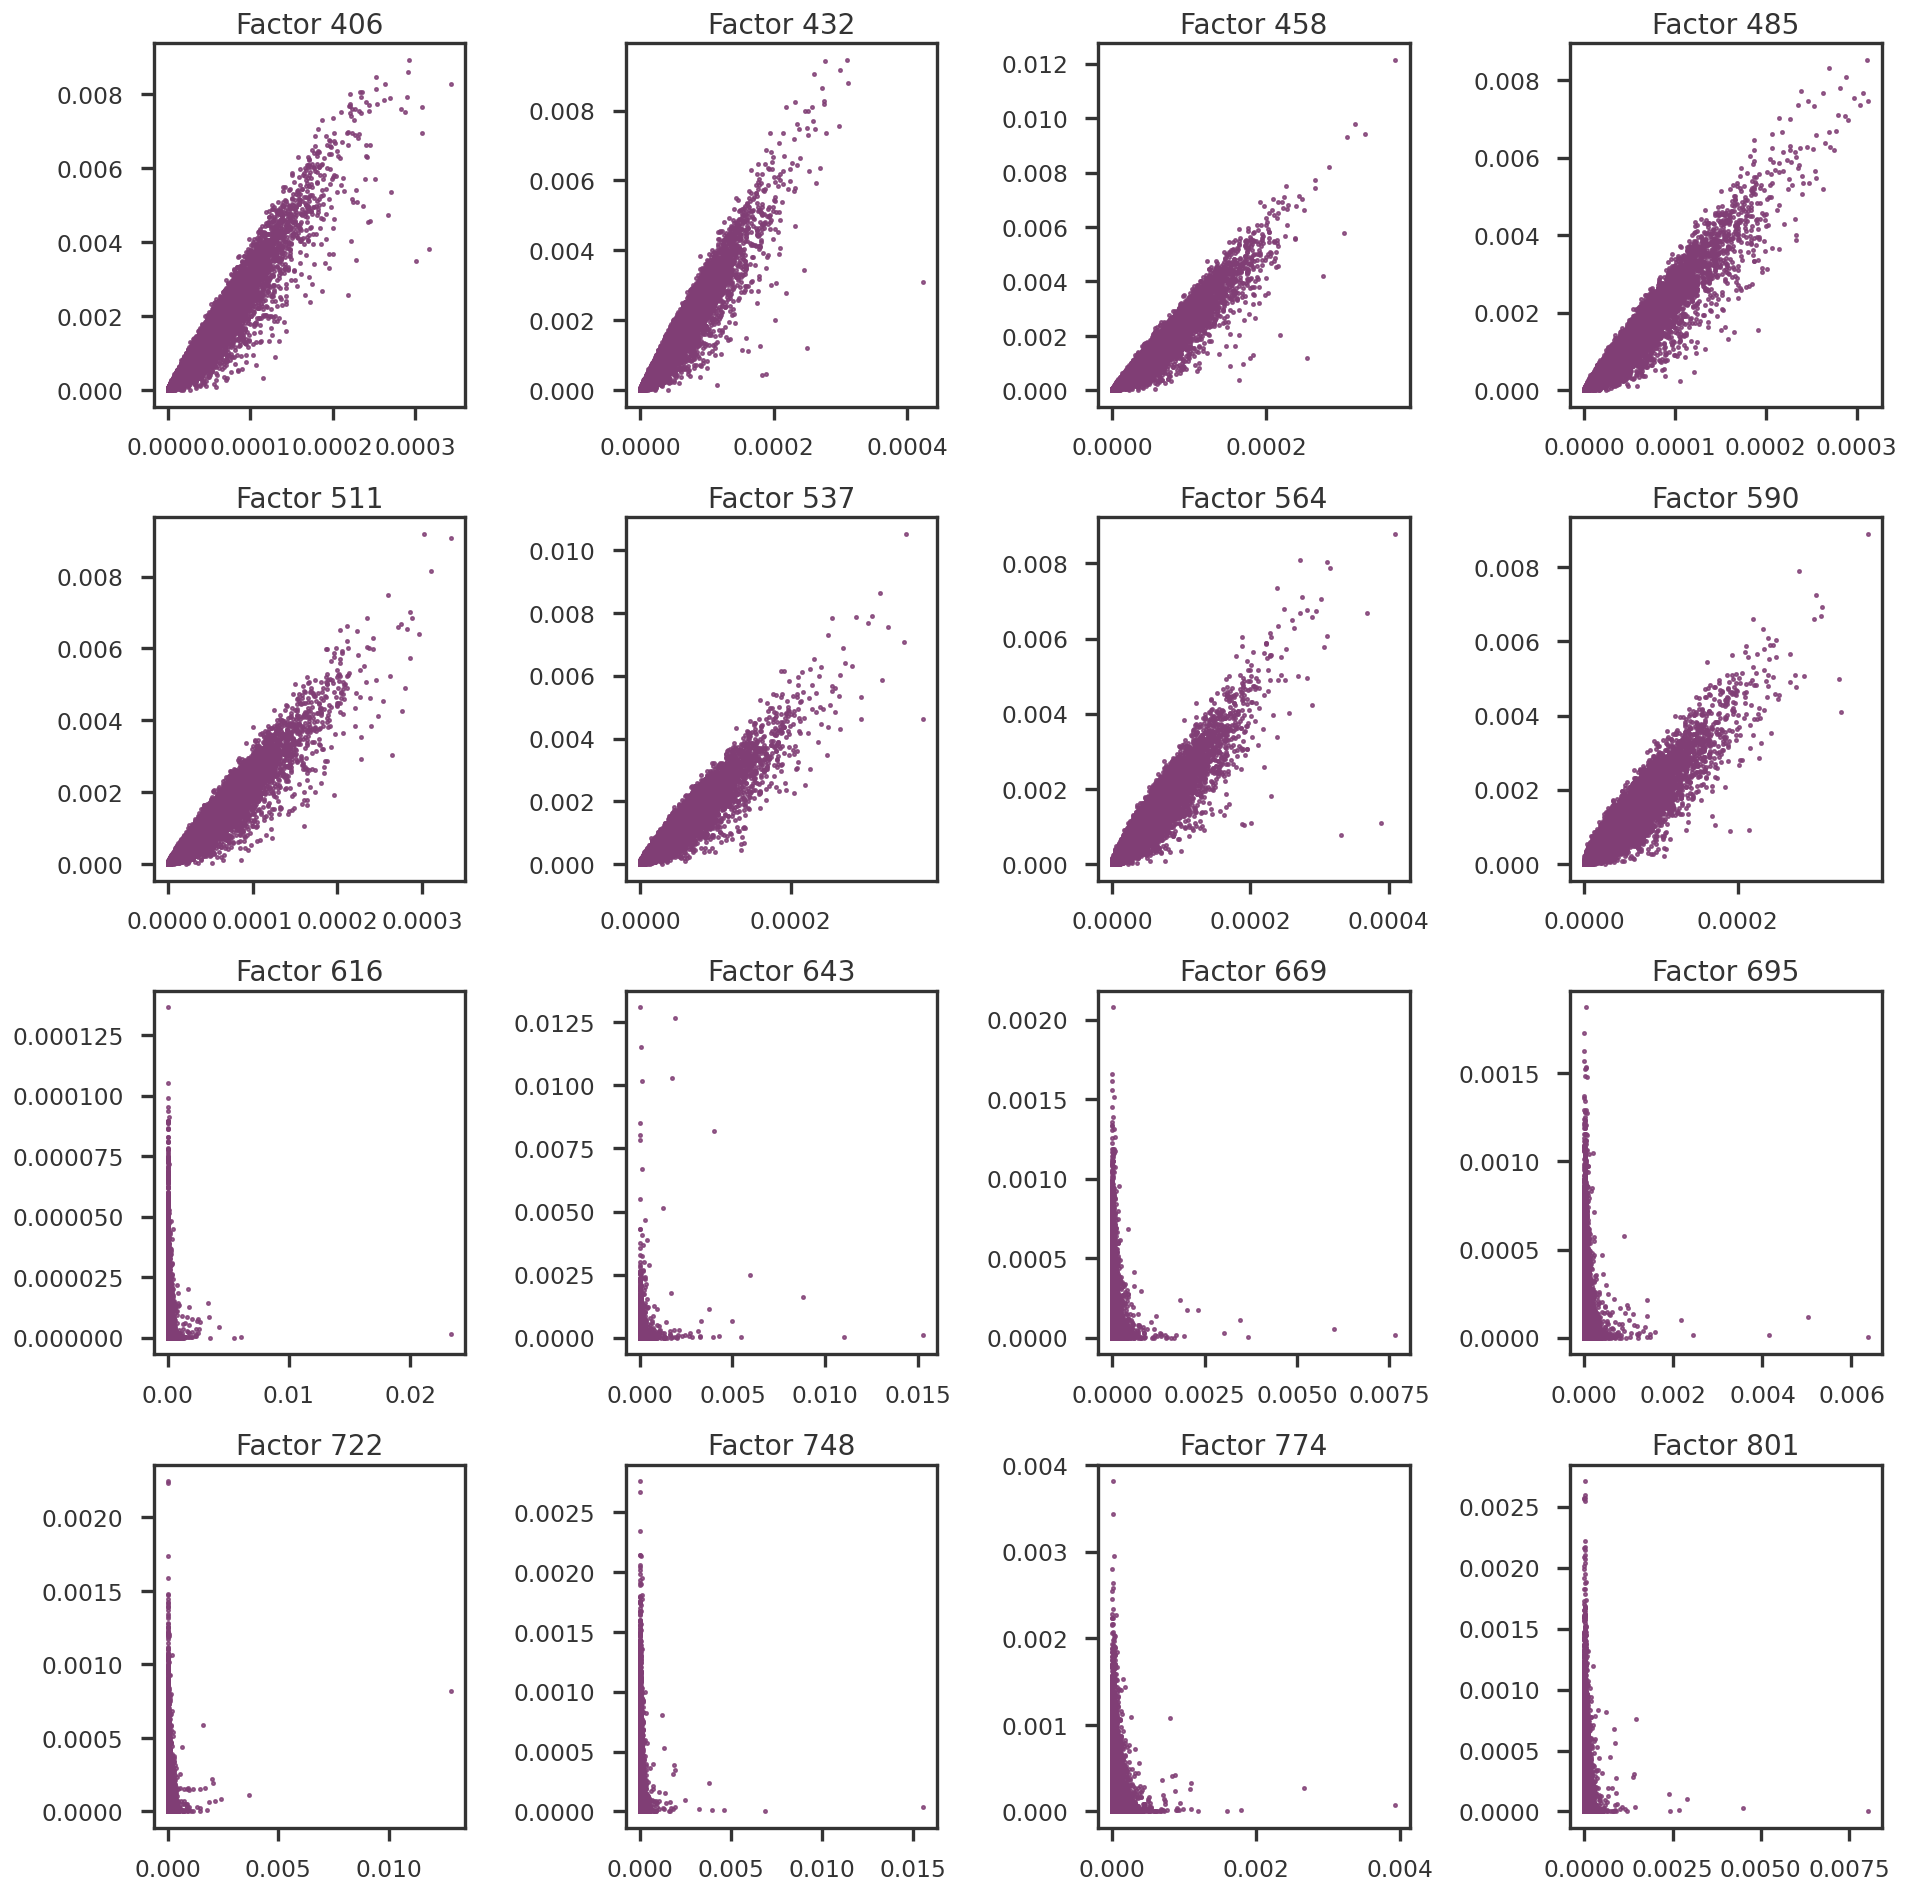

In [26]:
select_factors = np.linspace(405, 800, num = 16, dtype = int)

kbest_models_r2_405 = dict()
for ifact in select_factors:
    kbest_models_r2_405[ifact] = SelectKBest(r_regression, k = 100)
    kbest_models_r2_405[ifact].fit(X_cent, loadings_nnm[:, ifact])
    
fig = plt.figure(figsize = (16, 16))
axs = [None for i in range(16)]

for i in range(16):
    axs[i] = fig.add_subplot(4, 4, i+1)
    ifact = select_factors[i]
    axs[i].scatter(contribution_variant_nnm[:, ifact], 
                   np.square(kbest_models_r2_405[ifact].scores_),
                   s = 4, alpha = 0.8)
    axs[i].set_title(f"Factor {ifact + 1}")

plt.tight_layout()
plt.show()

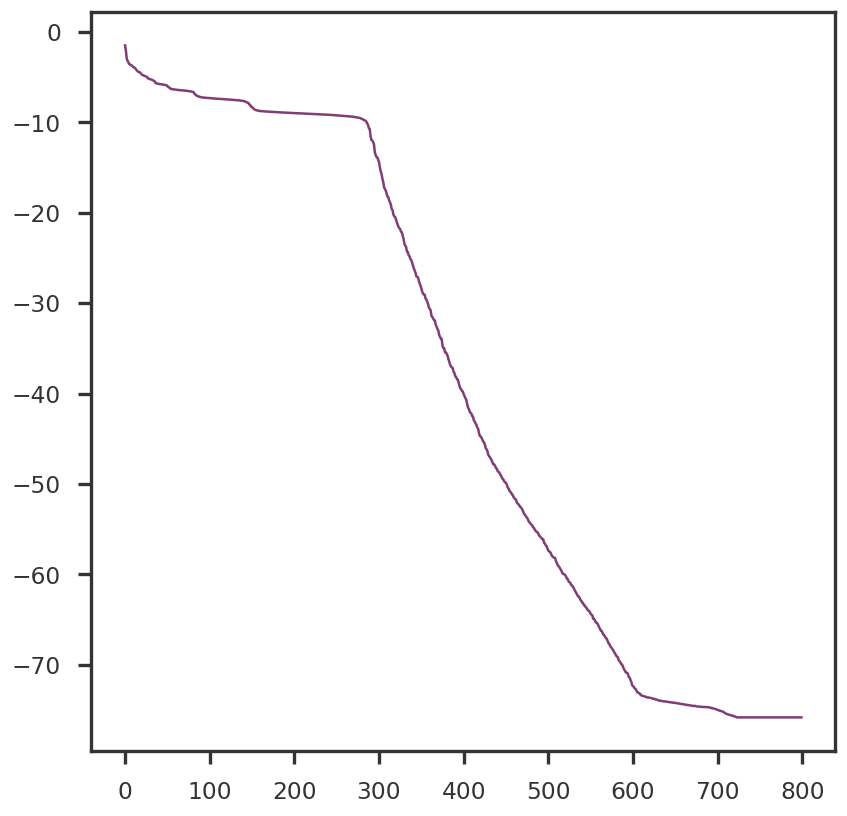

In [102]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

variances = S_nnm ** 2 / (X_cent.shape[0] - 1)
explained_variances = variances / np.sum(variances)
# ax1.plot(np.arange(S_nnm.shape[0]), np.log(explained_variances))
ax1.plot(np.arange(800), np.log(explained_variances[:800]))
plt.show()

In [ ]:
top_variant_idx = np.argsort(contribution_variant[:, top_factor])[::-1][:20]
top_variant_df = variant_df.loc[zscore_df.index.to_numpy()[top_variant_idx]]
top_variant_score = contribution_variant[top_variant_idx, top_factor]

In [41]:
nnm_factors_corr = get_pearsonr(factors_nnm.T[:, :itop], X_cent[:, :itop])
rpca_factors_corr = get_pearsonr(factors_rpca.T[:, :itop], X_cent[:, :itop])

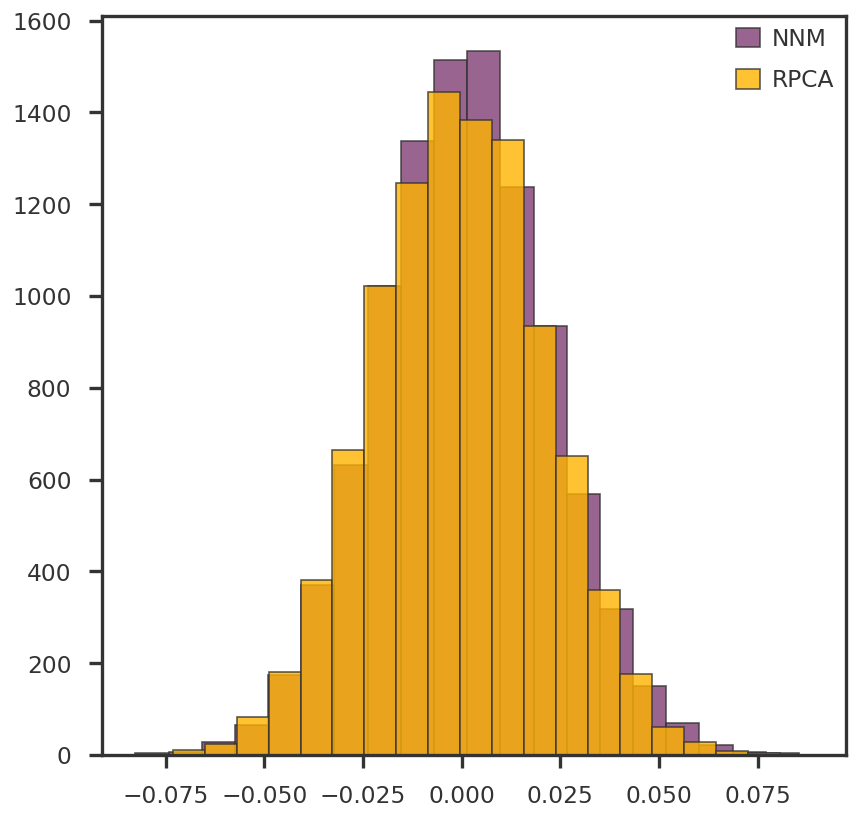

In [42]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)
ax1.hist(nnm_factors_corr, alpha = 0.8, label = "NNM")
ax1.hist(rpca_factors_corr, alpha = 0.8, label = "RPCA")

ax1.legend()
plt.show()

In [56]:
np.linalg.norm(rpca_model['E_'], ord = 1)

1904.994794867643

In [57]:
np.linalg.norm(rpca_model['L_'], ord = 'nuc')

147300.30652478684

In [28]:
np.linalg.norm(nnm_model['X_'], ord = 'nuc')

58573.41371357549

In [62]:
np.sqrt(np.min(nnm_model['Y_'].shape))

45.93473631142341

In [64]:
np.linalg.norm(nnm_model['Y_'], ord = 1) / np.sqrt(np.max(nnm_model['Y_'].shape))

17.703268026594692

In [34]:
np.linalg.matrix_rank(nnm_model['X_'])

472

In [52]:
np.linalg.norm(nnm_model['M_'], ord = 1)

17.703268026594685

In [44]:
nnm_model['l1_thres_']

17.703268026594692

In [45]:
from nnwmf.optimize import EuclideanProjection
G_half = nnm_model['X_'] - nnm_model['Y_']
M_old = nnm_model['M_']
X_old = M_old - G_half
X_flat = X_old.flatten()

In [50]:
eucp = EuclideanProjection(method = 'sort', target = 'l1')
eucp.fit(X_flat, a = 2000)
eucp.proj

array([-0.,  0., -0., ...,  0.,  0., -0.])

In [51]:
eucp.proj[np.where(eucp.proj != 0)[0]]

array([ 1.58389465e+00,  6.57180141e+00,  3.34330326e+00,  8.48976489e+00,
       -1.41571090e-01, -5.04913966e+00, -6.57815284e+00, -3.22100658e+01,
       -1.34310009e+01, -3.79411265e+00, -4.64416216e+00, -1.06688277e+01,
       -2.71356621e+01, -4.74076428e-01,  5.93043158e+00, -2.57973656e+00,
       -1.01736102e+01,  8.04387497e+00,  2.29511604e+01, -4.52171540e-01,
        1.46981111e+01, -4.99367506e-01,  6.68224584e+00,  1.03845090e+00,
       -1.88704332e+00, -4.19127507e+00, -1.15734692e+01, -1.46729391e+01,
       -8.38863426e+00, -4.07262538e+00, -2.29234116e+00, -1.23371137e+01,
       -2.46795014e+01, -1.60673045e-01,  1.58572778e+01,  1.00801565e+00,
       -7.83483066e+00,  5.53410657e-02, -3.66015271e+00,  1.77647581e+01,
        3.68284691e+00, -2.01867073e+00,  1.91432114e+01,  8.30256033e+00,
       -6.16850812e+00, -3.11170769e+01, -2.89483206e+00, -6.12145150e+00,
       -9.33402062e+00,  3.04922874e+00, -1.13772160e+00,  7.95501481e-01,
       -1.34838690e+00,  

In [40]:
len(nnm_model['st_list_'])

643

In [5]:
methods = ['input', 'rpca', 'nnm', 'nnm_sparse']
lowrank_model = dict()
for method in methods:
    if method != 'input':
        res_filename = os.path.join(result_dir, f"{method}_model.pkl")
        with (open(res_filename, "rb")) as fh:
            lowrank_model[method] = pickle.load(fh)

In [6]:
low_X = dict()
for method in methods:
    if method != 'input':
        low_X[method] = lowrank_model[method]['L_'] if method == 'rpca' else lowrank_model[method]['X_']
X = np.array(zscore_df.values.T)
low_X['input'] = X - np.mean(X, axis = 0, keepdims = True)

## Nuclear Norm 

In [7]:
for method in methods:
    nucnorm = np.linalg.norm(low_X[method], ord = 'nuc')
    print (f"{method}\t{nucnorm:.2f}")

input	431234.72
rpca	147300.31
nnm	8069.82
nnm_sparse	8059.14


## Matrix Rank

In [8]:
for method in methods:
    matrank = np.linalg.matrix_rank(low_X[method])
    print (f"{method}\t{matrank}")

input	2109
rpca	1198
nnm	28
nnm_sparse	28


## PanUKB cross-validation

In [2]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
mask_ratio = 0.2

zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_noRx.pkl"))
X = np.array(zscore_df.values.T)
Ztrue = X - np.mean(X, axis = 0, keepdims = True)
Zmask = dsc_simulate.generate_mask(X.shape[0], X.shape[1], mask_ratio)
Z = dsc_simulate.generate_masked_input(Ztrue, Zmask) # centered

In [3]:
np.sum(Zmask) / np.prod(Ztrue.shape)

0.2

In [4]:
"""
DSC function:
X, M, model = nnm_sparse(Z, max_iter = max_iter, mask = Zmask)
"""
from nnwmf.optimize import FrankWolfe, FrankWolfe_CV
nnm_sparse = FrankWolfe(model = 'nnm-sparse', max_iter = 10, svd_max_iter = 10, show_progress = True, debug = False)
nnm_sparse.fit(Z, (4, 1.0), mask = Zmask)

2024-08-21 16:19:58,773 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 1.000. Duality Gap 12842.2
2024-08-21 16:22:27,654 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-08-21 16:22:49,409 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 1. Step size 1.000. Duality Gap -1202.63
2024-08-21 16:22:49,411 | nnwmf.optimize.frankwolfe                | INFO    | Relative difference in objective function converged below tolerance.


In [ ]:
nnmcv = FrankWolfe_CV(model = 'nnm', max_iter = 10, svd_max_iter = 10, show_progress = True, debug = False)
rseq = np.array([1.0, 10.0, 100.0])
nnmcv.fit(Ztrue, rseq = rseq)

2024-08-21 16:28:05,088 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 1.000. Duality Gap 1573.76
2024-08-21 16:44:57,217 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 1.000. Duality Gap 1573.87
2024-08-21 16:47:28,316 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-08-21 16:47:29,877 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 2. Step size 1.000. Duality Gap -0.0642294
2024-08-21 16:47:29,878 | nnwmf.optimize.frankwolfe                | INFO    | Relative difference in objective function converged below tolerance.
2024-08-21 16:48:51,747 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 1.000. Duality Gap 14125.7
2024-08-21 16:51:22,590 | nnwmf.optimize.frankwolfe                | WARNING | Step Size is less than 0. Using last valid step size.
2024-08-21 16:53:56,573 | nnwmf.optimize.frankwolfe                

In [37]:
np.log(100)

4.605170185988092